# Analyse Exploratoire

### Import des modules

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [320]:
bc_df = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")
print(f"Dataset initial : {len(bc_df0)} bâtiments, {bc_df0.shape[1]} colonnes")

Dataset initial : 3371 bâtiments, 46 colonnes


In [321]:
# On regarde comment un batiment est défini dans ce jeu de données 
bc_df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Variables identifiées par catégories :  
- Identification :  
    OSEBuildingID, PropertyName, Address, City, State, ZipCode  
- Géolocalisation :   
    Latitude, Longitude, Neighborhood, CouncilDistrictCode  
- Caractéristiques physiques :   
    YearBuilt, NumberofFloors, PropertyGFATotal, PropertyGFABuilding(s)  
- Usage :   
    PrimaryPropertyType, ListOfAllPropertyUseTypes, LargestPropertyUseType  
- Performance énergétique :   
    YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf)  
- Consommation :   
    **SiteEnergyUse**, DataYear, Electricity(kWh) , Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu)   
- Émissions :   
    **TotalGHGEmissions**, GHGEmissionsIntensity (variables cibles potentielles)  


## Exclusion des lignes sans aucune valeur cible

In [322]:
target_cols = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
bc_df0 = bc_df.dropna(subset=target_cols, how='all').copy()
print(f"Après filtrage targets : {len(bc_df)} → {len(bc_df0)} bâtiments")

Après filtrage targets : 3376 → 3371 bâtiments


### Traitement des types d'utilisation principale des biens.

In [323]:
use_types = []
for i,row in bc_df0.iterrows():
    if not pd.isna(row['ListOfAllPropertyUseTypes']):
        for use in row['ListOfAllPropertyUseTypes'].split(','):
            use =  use.strip()
            if use not in use_types:
                use_types.append(use)
                print(use)
del use_types

Hotel
Parking
Restaurant
Swimming Pool
Police Station
Other - Entertainment/Public Assembly
Multifamily Housing
Data Center
Library
Fitness Center/Health Club/Gym
Office
Other
Other - Lodging/Residential
Social/Meeting Hall
Courthouse
K-12 School
College/University
Automobile Dealership
Retail Store
Self-Storage Facility
Energy/Power Station
Laboratory
Manufacturing/Industrial Plant
Non-Refrigerated Warehouse
Refrigerated Warehouse
Other - Education
Vocational School
Other - Mall
Personal Services (Health/Beauty
Dry Cleaning
etc)
Senior Care Community
Medical Office
Distribution Center
Hospital (General Medical & Surgical)
Museum
Repair Services (Vehicle
Shoe
Locksmith
Food Service
Residence Hall/Dormitory
Other - Services
Other/Specialty Hospital
Financial Office
Other - Utility
Fast Food Restaurant
Movie Theater
Supermarket/Grocery Store
Worship Facility
Lifestyle Center
Other - Recreation
Convenience Store without Gas Station
Pre-school/Daycare
Food Sales
Other - Restaurant/Bar
Sing

## Exclusion des outliers référencés

In [324]:
mask = ~bc_df0['Outlier'].isna()
bc_df1 = bc_df0[~mask].copy()
print(f"Après filtrage des types de propriétés : {len(bc_df0)} → {len(bc_df1)} bâtiments")


Après filtrage des types de propriétés : 3371 → 3339 bâtiments


## Exclusion des propriétés à usage d'habitation(non temporaire)

In [325]:
# Let's check property without largest use type
mask = bc_df1['LargestPropertyUseType'].isna()
bc_df1[mask][['ListOfAllPropertyUseTypes','BuildingType','PrimaryPropertyType','LargestPropertyUseType']].head(20)

,ListOfAllPropertyUseTypes,BuildingType,PrimaryPropertyType,LargestPropertyUseType
353,"Fitness Center/Health Club/Gym, Office, Other ...",NonResidential,Self-Storage Facility,NaN
1077,Multifamily Housing,Multifamily HR (10+),High-Rise Multifamily,NaN
1147,Hotel,NonResidential,Hotel,NaN
1483,Multifamily Housing,Multifamily MR (5-9),Mid-Rise Multifamily,NaN
1756,Multifamily Housing,Multifamily HR (10+),High-Rise Multifamily,NaN
1768,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2321,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2336,Multifamily Housing,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2414,Office,NonResidential,Small- and Mid-Sized Office,NaN
2459,Restaurant,NonResidential,Restaurant,NaN


In [326]:
bc_df1.at[353,'LargestPropertyUseType']= "Self-Storage Facility"
bc_df1.at[1077,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[1147,'LargestPropertyUseType']= "Hotel"
bc_df1.at[1483,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[1756,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[1768,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[2321,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[2336,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[2414,'LargestPropertyUseType']= "Office"
bc_df1.at[2459,'LargestPropertyUseType']= "Restaurant"
bc_df1.at[2480,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[2545,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[2886,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[3040,'LargestPropertyUseType']= "Multifamily Housing"
bc_df1.at[3348,'LargestPropertyUseType']= "Multifamily Housing"

In [327]:
exclude_first_use = ["Multifamily Housing", "Single Family Home","Residence Hall/Dormitory","Other - Lodging/Residential"]
mask = bc_df1["LargestPropertyUseType"].isin( exclude_first_use)
bc_df2 = bc_df1[~mask].copy()
print(f"Après filtrage des types de propriétés : {len(bc_df1)} → {len(bc_df2)} bâtiments")


Après filtrage des types de propriétés : 3339 → 1647 bâtiments


In [328]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
bc_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1647 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1647 non-null   int64  
 1   DataYear                         1647 non-null   int64  
 2   BuildingType                     1647 non-null   object 
 3   PrimaryPropertyType              1647 non-null   object 
 4   PropertyName                     1647 non-null   object 
 5   Address                          1647 non-null   object 
 6   City                             1647 non-null   object 
 7   State                            1647 non-null   object 
 8   ZipCode                          1631 non-null   float64
 9   TaxParcelIdentificationNumber    1647 non-null   object 
 10  CouncilDistrictCode              1647 non-null   int64  
 11  Neighborhood                     1647 non-null   object 
 12  Latitude                 

In [329]:
bc_df2[['SiteEnergyUse(kBtu)','TotalGHGEmissions']].corr()

,SiteEnergyUse(kBtu),TotalGHGEmissions
SiteEnergyUse(kBtu),1.000000,0.860086
TotalGHGEmissions,0.860086,1.000000


In [330]:
useless_cols = ['BuildingType', 'PropertyName', 'Address','City','State','ZipCode','DataYear', 'ENERGYSTARScore',"SiteEUIWN(kBtu/sf)",'SiteEnergyUseWN(kBtu)', 
                "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "Electricity(kWh)" , "NaturalGas(therms)","Outlier","TotalGHGEmissions",'GHGEmissionsIntensity',
                'YearsENERGYSTARCertified','DefaultData','Comments','ComplianceStatus','TaxParcelIdentificationNumber']
bc_df2.drop(columns=useless_cols, inplace=True)

In [331]:
mask = bc_df2['SiteEnergyUse(kBtu)'].isna() 
len(bc_df2[mask])

0

## Vérification des consommations

### Vérification surfaces

In [332]:
# remplis les qq propriétés sans valeurs de LargestPropertyUse
bc_df2['LargestPropertyUseTypeGFA'] = bc_df2['LargestPropertyUseTypeGFA'].fillna(bc_df2['PropertyGFATotal'])

In [333]:
bc_df2['SecondLargestPropertyUseTypeGFA'] = bc_df2['SecondLargestPropertyUseTypeGFA'].fillna(0)
bc_df2['ThirdLargestPropertyUseTypeGFA'] = bc_df2['ThirdLargestPropertyUseTypeGFA'].fillna(0)

gfa1 = bc_df2['LargestPropertyUseTypeGFA']  .where(bc_df2['LargestPropertyUseType']      != 'Parking', 0)
gfa2 = bc_df2['SecondLargestPropertyUseTypeGFA'].where(bc_df2['SecondLargestPropertyUseType'] != 'Parking', 0)
gfa3 = bc_df2['ThirdLargestPropertyUseTypeGFA'] .where(bc_df2['ThirdLargestPropertyUseType']  != 'Parking', 0)
bc_df2['ThreeLargestPropertyUseTypeGFA'] = gfa1 + gfa2 + gfa3
#bc_df2['TotalGFA_non_parking'] =  bc_df2[['PropertyGFABuilding(s)','TotalGFA_non_parking']].max(axis=1)

bc_df2['ThreeSEUI(kBtu/sf)'] = bc_df2['SiteEnergyUse(kBtu)'] / bc_df2['ThreeLargestPropertyUseTypeGFA']
bc_df2['CalcSUI(kBtu/sf)'] = bc_df2['SiteEnergyUse(kBtu)'] / bc_df2['PropertyGFABuilding(s)']


<Axes: xlabel='CalcSUI(kBtu/sf)'>

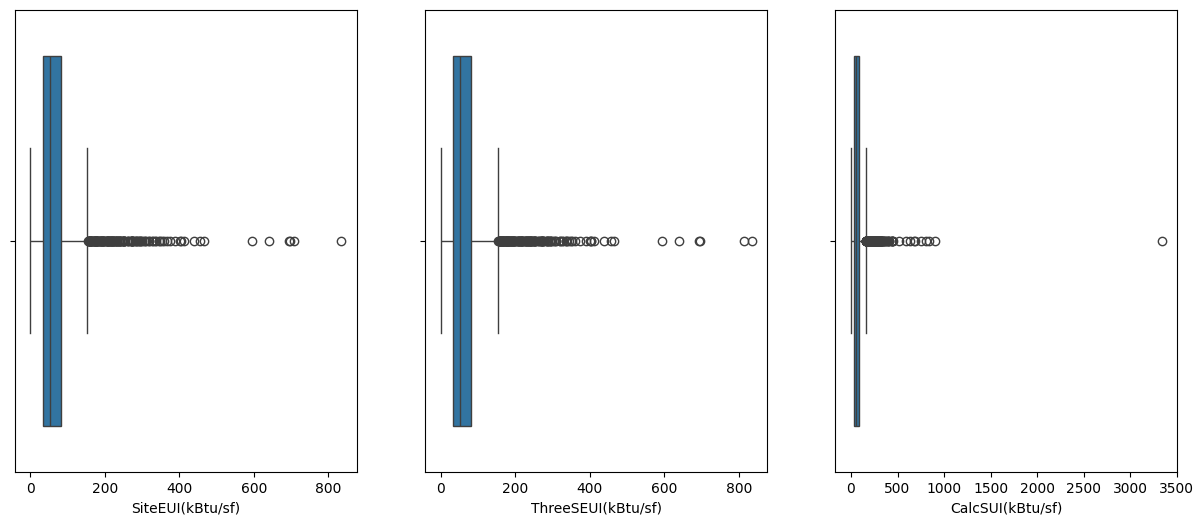

In [334]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
sns.boxplot(data = bc_df2,x = 'SiteEUI(kBtu/sf)', ax=ax[0])
sns.boxplot(data = bc_df2,x = 'ThreeSEUI(kBtu/sf)', ax=ax[1])
sns.boxplot(data = bc_df2,x = 'CalcSUI(kBtu/sf)', ax=ax[2])

In [335]:
Q1 = bc_df2['CalcSUI(kBtu/sf)'].quantile(0.01)
Q99 = bc_df2['CalcSUI(kBtu/sf)'].quantile(0.99)
bc_df3 = bc_df2[(bc_df2['CalcSUI(kBtu/sf)'] >= Q1) & 
                   (bc_df2['CalcSUI(kBtu/sf)'] <= Q99)].copy()
print(f"Après traitement outliers : {len(bc_df2)} → {len(bc_df3)} bâtiments")


Après traitement outliers : 1647 → 1613 bâtiments


<Axes: xlabel='CalcSUI(kBtu/sf)'>

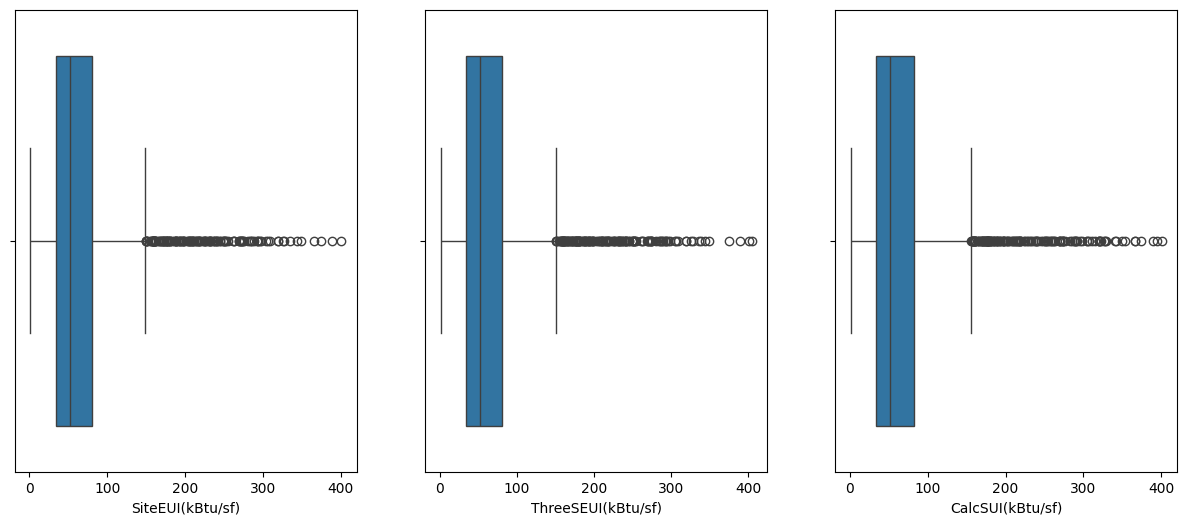

In [336]:
fig,ax = plt.subplots(1,3,figsize=(15,6))
sns.boxplot(data = bc_df3,x = 'SiteEUI(kBtu/sf)', ax=ax[0])
sns.boxplot(data = bc_df3,x = 'ThreeSEUI(kBtu/sf)', ax=ax[1])
sns.boxplot(data = bc_df3,x = 'CalcSUI(kBtu/sf)', ax=ax[2])

In [337]:

bc_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1613 non-null   int64  
 1   PrimaryPropertyType              1613 non-null   object 
 2   CouncilDistrictCode              1613 non-null   int64  
 3   Neighborhood                     1613 non-null   object 
 4   Latitude                         1613 non-null   float64
 5   Longitude                        1613 non-null   float64
 6   YearBuilt                        1613 non-null   int64  
 7   NumberofBuildings                1613 non-null   float64
 8   NumberofFloors                   1613 non-null   int64  
 9   PropertyGFATotal                 1613 non-null   int64  
 10  PropertyGFAParking               1613 non-null   int64  
 11  PropertyGFABuilding(s)           1613 non-null   int64  
 12  ListOfAllPropertyUseTypes

## Création des features

In [338]:
df_clean = bc_df3.copy()
df_clean['AgeProperty']= 2016 - df_clean['YearBuilt']
df_clean['UseElectricity']=df_clean['Electricity(kBtu)'].notna() & df_clean['Electricity(kBtu)']>0
df_clean['UseSteam']=df_clean['SteamUse(kBtu)'].notna() & df_clean['SteamUse(kBtu)']>0
df_clean['UseGas']=df_clean['NaturalGas(kBtu)'].notna() & df_clean['NaturalGas(kBtu)']>0
df_clean.drop(columns=['LargestPropertyUseType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType',
                       'ThirdLargestPropertyUseTypeGFA','PropertyGFAParking','PropertyGFATotal','ThreeLargestPropertyUseTypeGFA','ThreeSEUI(kBtu/sf)'],inplace=True)
df_clean.drop(columns=['YearBuilt','Electricity(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SiteEUI(kBtu/sf)','CalcSUI(kBtu/sf)','SteamUse(kBtu)'],inplace=True)

In [339]:
df_clean['AvgFloor'] = df_clean['NumberofFloors']/df_clean['NumberofBuildings']
df_clean.drop(columns=['NumberofFloors','NumberofBuildings'],inplace=True)

In [318]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613 entries, 0 to 3375
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              1613 non-null   int64  
 1   PrimaryPropertyType        1613 non-null   object 
 2   CouncilDistrictCode        1613 non-null   int64  
 3   Neighborhood               1613 non-null   object 
 4   Latitude                   1613 non-null   float64
 5   Longitude                  1613 non-null   float64
 6   PropertyGFABuilding(s)     1613 non-null   int64  
 7   ListOfAllPropertyUseTypes  1613 non-null   object 
 8   SiteEnergyUse(kBtu)        1613 non-null   float64
 9   AgeProperty                1613 non-null   int64  
 10  UseElectricity             1613 non-null   bool   
 11  UseSteam                   1613 non-null   bool   
 12  UseGas                     1613 non-null   bool   
 13  AvgFloor                   1612 non-null   float64
dt

In [340]:
df_clean['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    288
Other                          238
Warehouse                      187
Large Office                   170
K-12 School                    123
Mixed Use Property             103
Retail Store                    89
Hotel                           76
Worship Facility                69
Distribution Center             53
Senior Care Community           44
Medical Office                  39
Supermarket / Grocery Store     38
Self-Storage Facility           28
University                      25
Refrigerated Warehouse          11
Restaurant                      11
Hospital                         9
Laboratory                       9
Office                           3
Name: count, dtype: int64

In [342]:
df_clean['Neighborhood'] = df_clean['Neighborhood'].str.upper()
df_clean['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                  348
GREATER DUWAMISH          340
MAGNOLIA / QUEEN ANNE     146
LAKE UNION                142
EAST                      117
NORTHEAST                 110
NORTHWEST                  89
NORTH                      73
BALLARD                    67
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   45
SOUTHWEST                  38
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

df_cle

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

# Modélisation 

### Import des modules 

In [72]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

In [73]:
# CODE FEATURE ENGINEERING

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

In [74]:
# CODE PREPARATION DES FEATURES

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [75]:
# CODE COMPARAISON DES MODELES

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [76]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE